In [2]:
import os
import random

import numpy as np
import seaborn as sns
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader
from IPython.display import clear_output

import matplotlib.pyplot as plt
from sklearn.datasets import make_swiss_roll
from sklearn.utils import shuffle
from tqdm import tqdm
from copy import deepcopy
from typing import Optional, Tuple, List

T_min = 1e-2

device = "cuda" if torch.cuda.is_available() else "cpu"
print("Using device:", device)

Using device: cpu


## Данные

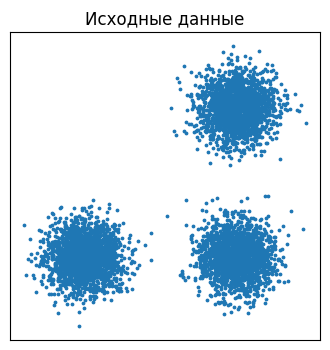

In [3]:
ds_size, ds_dim = 2000, 2

mu1, sigma1 = np.array([-1, -1]), 0.25
mu2, sigma2 = np.array([1, 1]), 0.25
mu3, sigma3 = np.array([1, -1]), 0.25

X1 = np.random.randn(ds_size, ds_dim) * sigma1 + mu1
X2 = np.random.randn(ds_size, ds_dim) * sigma2 + mu2
X3 = np.random.randn(ds_size, ds_dim) * sigma3 + mu3
X_np = np.concatenate([X1, X2, X3], axis=0)

plt.figure(figsize=(4, 4))
plt.scatter(x=X_np[:, 0], y=X_np[:, 1], s=3)
plt.title("Исходные данные")
plt.xticks([]); plt.yticks([])
plt.show()

## Прямой СДУ

Наша цель — задать **прямой диффузионный процесс**, который берёт объекты данных $x(0)$ и к моменту $t=1$ превращает их распределение в почти стандартный гауссовский шум.

Рассмотрим стохастическое дифференциальное уравнение общего вида
$$
dx = f(x, t)\,dt + g(x, t)\,dW_t,
$$
где $W_t$ — винеровский процесс, $f$ — дрейф, $g$ — коэффициент при шуме.

Чтобы использовать такое СДУ в качестве прямого процесса диффузионной модели, нам нужно, чтобы

- при $t = 0$ процесс стартовал с распределения данных;
- при $t \to 1$ распределение стало близко к $\mathcal{N}(0, I)$.

Опираясь на дискретный процесс DDPM, возьмём прямой процесс вида
$$
dx = -\tfrac{1}{2}\beta(t)\,x\,dt + \sqrt{\beta(t)}\,dW_t.
$$

Для этого процесса условное распределение в момент времени $t$ при фиксированном объекте данных $x(0)$ имеет вид
$$
p_t(x(t)\mid x(0)) =
\mathcal{N}\Big(
x(t)\,\Big|\,
x(0)\,\exp\Big(-\tfrac{1}{2}\gamma(t)\Big),
\;
\big(1 - \exp\big(-\gamma(t)\big)\big)\,I
\Big),
$$
где
$$
\gamma(t) = \int_0^t \beta(s)\,ds
$$
— непрерывный аналог $\bar{\alpha}_t$ из DDPM.

Следуя DDPM, зададим $\beta(t)$ линейной функцией:
$$
\beta(t) = \beta_{\min} + t\big(\beta_{\max} - \beta_{\min}\big).
$$

Тогда
$$
\gamma(t)
= \int_0^t \beta(s)\,ds
= \int_0^t \big(\beta_{\min} + s(\beta_{\max} - \beta_{\min})\big)\,ds
= \beta_{\min} t + \tfrac{1}{2}(\beta_{\max} - \beta_{\min}) t^2.
$$

Подставляя это в формулу для условного распределения, получаем
$$
p_t(x(t)\mid x(0)) =
\mathcal{N}\Big(
x(t)\,\Big|\,
x(0)\,\exp\Big(
-\tfrac{1}{2}\beta_{\min} t
-\tfrac{1}{4}(\beta_{\max} - \beta_{\min}) t^2
\Big),
\;
\big(
1 - \exp\big(
-\beta_{\min} t
-\tfrac{1}{2}(\beta_{\max} - \beta_{\min}) t^2
\big)
\big)\,I
\Big).
$$


In [ ]:
# Параметры, аналогичные расписанию β_t в DDPM (дискретный случай)
BETA_MIN_DISCRETE = 1e-4
BETA_MAX_DISCRETE = 2e-2
T_STEPS = 1000  # число шагов в DDPM

# Для непрерывного времени t ∈ [0, 1] хотим, чтобы
# ∫_0^1 β(t) dt был того же порядка, что и сумма дискретных β_t.
# Поэтому масштабируем границы:
BETA_MIN = BETA_MIN_DISCRETE * T_STEPS
BETA_MAX = BETA_MAX_DISCRETE * T_STEPS


def beta(t):
    """Функция β(t), задающая скорость зашумления в прямом СДУ."""
    return BETA_MIN + t * (BETA_MAX - BETA_MIN)

def gamma_t(t):
    """Вычисляет γ(t) = ∫_0^t β(s) ds.

    Эта величина γ(t) используется в аналитических формулах
    для маргиналов p_t(x(t) | x(0)).
    """
    return BETA_MIN * t + 0.5 * (BETA_MAX - BETA_MIN) * t**2

def marginal_mean_std(x0, t):
    """Считает среднее и стандартное отклонение маргиналов p_t(x(t) | x(0)).

    Теоретически:
      m(t) = x(0) · exp(-½ γ(t)),
      v(t) = 1 - exp(-γ(t)),
      std(t) = sqrt(v(t)).
    """
    if not torch.is_tensor(t):
        t = torch.tensor(t, dtype=x0.dtype, device=x0.device)

    gamma = gamma_t(t).view(-1, 1)

    mean = x0 * torch.exp(-0.5 * gamma)
    var = 1.0 - torch.exp(-gamma)
    std = torch.sqrt(var)

    return mean, std

def sample_marginal(x0, t) -> torch.Tensor:
    """Одношаговое семплирование из аналитического маргинала p_t(x(t) | x(0))."""
    mean, std = marginal_mean_std(x0, t)
    eps = torch.randn_like(mean)
    return mean + std * eps

In [ ]:
def visualize_marginal_forward(x0_np, ts, num_samples=2000):
    """Визуализирует одношаговое семплирование из аналитических маргиналов p_t(x(t) | x(0)).

    Для каждого момента времени t ∈ ts:
      1. Берём подмножество исходных точек x(0);
      2. Семплируем x(t) ~ p_t(x(t) | x(0)) с помощью sample_marginal;
      3. Рисуем получившееся распределение в 2D.

    Позже мы сравним эти картинки с численным решением прямого СДУ
    методом Эйлера–Маруямы.
    """
    x0 = torch.from_numpy(x0_np).to(device)

    # Ограничиваем число точек, чтобы картинка оставалась читаемой
    if x0.shape[0] > num_samples:
        idx = torch.randint(0, x0.shape[0], (num_samples,), device=device)
        x0 = x0[idx]

    ts_tensor = torch.tensor(ts, dtype=torch.float32, device=device)
    n_t = len(ts)

    fig, axes = plt.subplots(1, n_t, figsize=(4 * n_t, 4), squeeze=False)

    for ax, t in zip(axes[0], ts_tensor):
        # Семплируем x(t) из аналитического маргинала p_t(x(t) | x(0))
        xt = sample_marginal(x0, t)
        xt_np = xt.detach().cpu().numpy()

        ax.scatter(xt_np[:, 0], xt_np[:, 1], s=3)
        ax.set_title(f"t = {float(t):.2f}")
        ax.set_xticks([])
        ax.set_yticks([])

    plt.tight_layout()
    plt.show()

ts = [0.0, 0.1, 0.2, 0.25, 0.3, 1.0]
visualize_marginal_forward(X_np, ts, num_samples=2000)

Давайте проверим, что маргинальные распределения, получающиеся при пошаговом
решении прямого СДУ, совпадают с аналитическими распределениями
$$
p_t(x \mid x(0)),
$$
которые мы получили для одного шага.

Прямое СДУ мы будем решать с помощью метода Эйлера–Маруямы. Напомним, что для
общего СДУ
$$
dx = f(x,t)\, dt + g(x,t)\, dW_t,
$$
его дискретизация методом Эйлера–Маруямы с шагом $\Delta t$ задаётся формулой
$$
x(t + \Delta t)
=
x(t)
+
f(x(t), t)\, \Delta t
+
g(x(t), t)\, \sqrt{\Delta t}\, \epsilon,
\qquad
\epsilon \sim \mathcal{N}(0, I).
$$

Если применить это к нашему конкретному прямому СДУ
$$
dx = -\tfrac{1}{2}\beta(t)\,x\,dt + \sqrt{\beta(t)}\,dW_t,
$$
то получим шаг
$$
x(t + \Delta t)
=
x(t)
-\tfrac{1}{2}\beta(t)\,x(t)\,\Delta t
+ \sqrt{\beta(t)}\,\sqrt{\Delta t}\,\epsilon,
\qquad
\epsilon \sim \mathcal{N}(0, I).
$$

Далее мы будем сравнивать распределения, полученные
1) по этой пошаговой схеме,
2) из аналитических маргиналов $p_t(x \mid x(0))$,
для одних и тех же моментов времени $t$.


In [ ]:
def euler_maruyama_forward_step(x_t, t, dt):
    """Один шаг метода Эйлера–Маруямы для прямого СДУ.

    СДУ:
      dx = -½ β(t) x dt + √β(t) dW_t.

    Дискретизация:
      x(t + Δt) = x(t) - ½ β(t) x(t) Δt + √β(t) √Δt ε, ε ~ N(0, I).
    """
    if not torch.is_tensor(t):
        t = torch.tensor(t, dtype=x_t.dtype, device=x_t.device)

    beta_t = beta(t).view(-1, 1)

    drift = -0.5 * beta_t * x_t          # детерминированная часть шага
    diffusion = torch.sqrt(beta_t)       # коэффициент при шуме

    noise = torch.randn_like(x_t)        # ε ~ N(0, I)
    x_next = x_t + drift * dt + diffusion * (dt ** 0.5) * noise
    return x_next


def simulate_forward_sde(x0, t_final, n_steps=1000):
    """Численное решение прямого СДУ от t = 0 до t = t_final методом Эйлера–Маруямы.

    Пошагово применяем euler_maruyama_forward_step с равномерным шагом Δt.
    """
    x_t = x0.clone().to(device)
    dt = float(t_final) / n_steps

    t = 0.0
    for _ in range(n_steps):
        x_t = euler_maruyama_forward_step(x_t, t, dt)
        t += dt

    return x_t

In [ ]:
def visualize_sde_forward(x0_np, ts, n_sde_steps=1000, n_samples=2000):
    """Визуализирует численное решение прямого СДУ методом Эйлера–Маруямы.

    Для каждого момента времени t ∈ ts:
      1. Берём подмножество исходных точек x(0);
      2. Численно интегрируем прямое СДУ от t=0 до t=t_final;
      3. Рисуем распределение x(t_final) в 2D.

    Эти картинки можно напрямую сравнивать с результатами
    visualize_marginal_forward, где использовались аналитические маргиналы
    p_t(x(t) | x(0)).
    """
    x0_np_sub = x0_np
    if x0_np_sub.shape[0] > n_samples:
        idx = np.random.choice(x0_np_sub.shape[0], n_samples, replace=False)
        x0_np_sub = x0_np_sub[idx]

    x0 = torch.from_numpy(x0_np_sub).to(device)

    n_t = len(ts)
    fig, axes = plt.subplots(1, n_t, figsize=(4 * n_t, 4), squeeze=False)
    axes = axes[0]

    for ax, t_final in zip(axes, ts):
        # Численно решаем прямое СДУ от t = 0 до t = t_final
        x_t = simulate_forward_sde(x0, t_final=t_final, n_steps=n_sde_steps)
        x_t_np = x_t.detach().cpu().numpy()

        ax.scatter(x=x_t_np[:, 0], y=x_t_np[:, 1], s=3)
        ax.set_title(f"t = {t_final:.2f}")
        ax.set_xticks([])
        ax.set_yticks([])

    plt.tight_layout()
    plt.show()

ts = [0.0, 0.1, 0.2, 0.25, 0.3, 1.0]
visualize_sde_forward(X_np, ts, n_sde_steps=1000, n_samples=2000)

## Генерация

### 1. Обратный СДУ

На лекции мы разбирали, что если прямой диффузионный процесс задаётся СДУ
$$
dx_t = f(t,x_t)\,dt + g(t)\,dW_t, \qquad t: 0 \rightarrow 1,
$$
то эквивалентный обратный процесс имеет вид
$$
dx_t = \bigl(f(t,x_t) - g(t)^2 \,\nabla_x \log p_t(x_t)\bigr)\,dt
+ g(t)\,d\bar W_t,
\qquad t: 1 \rightarrow 0.
$$

Ключевое отличие: в дрейфе появляется член
$\nabla_x \log p_t(x)$ — скор распределения $p_t$,
который “толкает” траекторию от шума обратно к данным.

---

### 2. Нейросеть для оценки скор-функции

Чтобы генерировать новые данные, нужно уметь **интегрировать обратное СДУ**.  
Но формула обратного процесса требует знания скора $\nabla_x \log p_t(x)$.

Распределение $p_t(x)$ неизвестно, следовательно, его скор тоже неизвестен.

Поэтому вводим нейросетевую аппроксимацию:
$$
s_\theta(x,t) \approx \nabla_x \log p_t(x),
$$
и обучаем её предсказывать скор для каждого момента времени $t$.

После обучения мы подставляем $s_\theta(x_t, t)$ вместо
$\nabla_x \log p_t(x_t)$ в обратное СДУ — так пошаговая эволюция
начального шума превращается в выборку, похожую на данные.

---

### 3. Лосс для обучения скора

Прямой процесс даёт аналитическую формулу для условного распределения:
$$
p_t(x(t) \mid x(0)) = \mathcal N(x(t) \mid \mu_t(x(0)), \sigma_t^2\,I),
$$
то есть
$$
x(t) = \mu_t(x(0)) + \sigma_t\,\epsilon,
\qquad \epsilon \sim \mathcal N(0,I).
$$

Для такого распределения скор выражается в явном виде:
$$
\nabla_x \log p_t(x(t) \mid x(0))
= -\,\frac{1}{\sigma_t^2}\,\bigl(x(t) - \mu_t(x(0))\bigr).
$$

На одной из предыдущих лекций мы показывали, что **безусловную**
скор-функцию можно искать как минимизатор следующей функции потерь:
$$
\mathcal L_{\text{score}}(\theta)
=
\mathbb{E}_{t,\,x(0),\,x(t)}
\|
s_\theta(x(t), t)
-
\nabla_x \log p_t(x(t) \mid x(0))
\|^2.
$$

Здесь $x(t)$ порождается прямым процессом из данных $x(0)$, а
$s_\theta(x(t), t)$ обучается приближать истинный скор
$\nabla_x \log p_t(x(t))$.


In [ ]:
def euler_maruyama_backward_step(score, x_t, t, dt):
    """Один шаг метода Эйлера–Маруямы для *обратного* СДУ.

    Обратный процесс для нашего прямого СДУ имеет вид:
      dx = [-½ β(t) x - β(t) ∇_x log p_t(x)] dt + √β(t) d\bar W_t.

    Мы интегрируем его "назад по времени", от t=1 к t=0, с шагом dt > 0:
      x_{t - dt} ≈ x_t - drift(t, x_t) · dt + √β(t) √dt · ε, ε ~ N(0, I),
    где drift(t, x) = -½ β(t) x - β(t) score(x, t).
    """
    if not torch.is_tensor(t):
        t = torch.tensor(t, dtype=x_t.dtype, device=x_t.device)

    beta_t = beta(t).view(-1, 1)

    drift = -0.5 * beta_t * x_t - beta_t * score  # дрейф обратного СДУ
    diffusion = torch.sqrt(beta_t)                # коэффициент при шуме

    noise = torch.randn_like(x_t)                 # ε ~ N(0, I)
    x_next = x_t - drift * dt + diffusion * (dt ** 0.5) * noise
    return x_next

def simulate_backward_sde(score_model, x_T, t_final=T_min, n_steps=1000):
    """Численное решение обратного СДУ от t = 1 до t = t_final.

    Стартуем с x_T ~ N(0, I) при t=1 и по шагам идём к меньшим t,
    используя оценку скора от модели score_model.
    """
    x_t = x_T.clone().to(device)
    dt = (1.0 - t_final) / n_steps  # положительный шаг по времени

    t = 1.0
    for _ in range(n_steps):
        # В каждый момент времени t оцениваем скор для текущих точек x_t
        t_tensor = torch.ones(x_t.shape[0], device=x_t.device) * t
        score = score_model(x_t, t_tensor)

        x_t = euler_maruyama_backward_step(score, x_t, t, dt)
        t -= dt  # двигаемся от 1 к 0

    return x_t


@torch.no_grad()
def sample_from_diffusion_sde(score_model, num_samples=2000, n_steps=1000):
    """Сэмплирование из диффузионной модели через интегрирование обратного СДУ.

    1. Семплируем x(1) ~ N(0, I);
    2. Интегрируем обратное СДУ от t=1 до t=0;
    3. Получаем приближение выборки из распределения данных.
    """
    x_1 = torch.randn(num_samples, 2, device=device)
    x_0 = simulate_backward_sde(score_model, x_1, n_steps=n_steps)
    samples_np = x_0.detach().cpu().numpy()

    plt.figure(figsize=(4, 4))
    plt.scatter(x=samples_np[:, 0], y=samples_np[:, 1], s=3)
    plt.title("Сэмплы из обратного СДУ")
    plt.xticks([])
    plt.yticks([])
    plt.show()

In [ ]:
class ScoreNet(nn.Module):
    """Простая нейросеть для аппроксимации скор-функции s_θ(x, t)."""

    def __init__(self, x_dim=2, hidden_dim=32):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(x_dim + 1, hidden_dim),
            nn.SiLU(),
            nn.Linear(hidden_dim, hidden_dim),
            nn.SiLU(),
            nn.Linear(hidden_dim, hidden_dim),
            nn.SiLU(),
            nn.Linear(hidden_dim, x_dim),
        )

    def forward(self, x, t):
        # На вход подаём точку x и скалярное время t, конкатенируем по признакам
        if not torch.is_tensor(t):
            t = torch.tensor(t, dtype=x.dtype, device=x.device)

        t = t.view(-1, 1).to(x.device, x.dtype)
        inp = torch.cat([x, t], dim=1)
        return self.net(inp)

In [ ]:
def compute_score_loss(model, x0):
    """Вычисляет функцию потерь для обучения скор-модели.

    1. Семплируем момент времени t ~ Uniform(t_min, 1);
    2. Строим x(t) по аналитическим маргиналам:
         x(t) = μ_t(x0) + σ_t ε;
    3. Считаем истинный скор условного распределения:
         target_score = - (x(t) - μ_t(x0)) / σ_t^2;
    4. Обучаем s_θ(x(t), t) приближать этот скор по MSE.
    """
    model.train()
    x0 = x0.float()
    N = x0.shape[0]

    t_min = T_min  # чтобы избежать слишком малых σ_t
    t = torch.rand(N, dtype=x0.dtype, device=x0.device) * (1 - t_min) + t_min

    mean, std = marginal_mean_std(x0, t)
    mean, std = mean.view(N, -1), std.view(N, -1)

    eps = torch.randn_like(x0)
    x_t = mean + std * eps

    target_score = -(x_t - mean) / (std ** 2)
    pred_score = model(x_t, t)

    loss = ((pred_score - target_score) ** 2).sum(dim=1).mean()
    return loss

In [ ]:
def train_score_model(model, X, n_iters=15000, batch_size=256, lr=1e-3, log_every=1000):
    """Обучение скор-модели на данных X с использованием compute_score_loss."""
    if not torch.is_tensor(X):
        X = torch.from_numpy(X).float()

    dataset = torch.utils.data.TensorDataset(X)
    loader = DataLoader(dataset, batch_size=batch_size, shuffle=True, drop_last=True)

    optimizer = torch.optim.Adam(model.parameters(), lr=lr)

    data_iter = iter(loader)
    step = 0
    loss_log = 0
    while step < n_iters:
        try:
            (batch,) = next(data_iter)
        except StopIteration:
            data_iter = iter(loader)
            (batch,) = next(data_iter)

        loss = compute_score_loss(model, batch)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        loss_log += loss.item() / log_every

        if (step + 1) % log_every == 0:
            print(f"Step {step + 1:03d} | loss = {loss_log:.6f}")
            loss_log = 0

        step += 1

In [ ]:
score_model = ScoreNet(x_dim=2, hidden_dim=64)

sample_from_diffusion_sde(score_model, num_samples=4000, n_steps=1000)
# sample_from_diffusion_ode(score_model, num_samples=4000, n_steps=1000)

n_epochs = 1
for _ in range(n_epochs):
    train_score_model(score_model, X_np, n_iters=5000, batch_size=512, lr=3e-4, log_every=500)
    clear_output()
    sample_from_diffusion_sde(score_model, num_samples=4000, n_steps=1000)
    # sample_from_diffusion_ode(score_model, num_samples=4000, n_steps=1000)

### Эквивалентный ОДУ

На лекции мы говорили, что для генерации можно использовать не только обратное СДУ, как мы делали выше, но и **эквивалентное ему ОДУ**, которое имеет те же маргинальные распределения $p_t(x)$.

В общем случае, если обратный диффузионный процесс задаётся СДУ
$$
dx_t = \bigl(f(t,x_t) - g(t)^2 \,\nabla_x \log p_t(x_t)\bigr)\,dt
+ g(t)\,d\bar W_t,
\qquad t: 1 \rightarrow 0,
$$
то эквивалентное ему **ОДУ потока вероятностей** (probability flow ODE) записывается как
$$
dx_t = \bigl(f(t,x_t) - \tfrac{1}{2}g(t)^2 \,\nabla_x \log p_t(x_t)\bigr)\,dt.
$$

В нашем конкретном случае прямое СДУ имеет вид
$$
dx_t = -\tfrac{1}{2}\beta(t)\,x_t\,dt + \sqrt{\beta(t)}\,dW_t,
$$
то есть
$$
f(t, x_t) = -\tfrac{1}{2}\beta(t)\,x_t,
\qquad
g(t)^2 = \beta(t).
$$

Тогда соответствующее ОДУ потока вероятностей принимает форму
$$
dx_t
=
\Bigl(
-\tfrac{1}{2}\beta(t)\,x_t
-\tfrac{1}{2}\beta(t)\,\nabla_x \log p_t(x_t)
\Bigr)\,dt,
\qquad t: 1 \rightarrow 0.
$$

Давайте переиспользуем нашу предобученную скор-модель и подставим
$s_\theta(x_t, t) \approx \nabla_x \log p_t(x_t)$ в это ОДУ, чтобы
семплировать траектории **без шума**, но с теми же маргинальными распределениями, что и у обратного СДУ.


In [ ]:
def euler_backward_step(score, x_t, t, dt):
    """Один шаг метода Эйлера для *обратного ОДУ потока вероятностей*.

    ОДУ:
      dx_t = [ -½ β(t) x_t - ½ β(t) ∇_x log p_t(x_t) ] dt.

    Мы интегрируем его "назад по времени", от t=1 к t=0, с шагом dt > 0:
      x_{t - dt} ≈ x_t - drift(t, x_t) · dt,
    где drift(t, x) = -½ β(t) x - ½ β(t) score(x, t).
    """
    if not torch.is_tensor(t):
        t = torch.tensor(t, dtype=x_t.dtype, device=x_t.device)

    beta_t = beta(t).view(-1, 1)

    # Дрейф эквивалентного ОДУ (без шумового члена)
    drift = -0.5 * beta_t * x_t - 0.5 * beta_t * score

    # Делаем шаг назад во времени: t -> t - dt
    x_next = x_t - drift * dt
    return x_next


def simulate_backward_ode(score_model, x_T, t_final=T_min, n_steps=1000):
    """Численное решение эквивалентного ОДУ от t = 1 до t = t_final.

    Стартуем с x_T ~ N(0, I) при t=1 и по шагам идём к меньшим t,
    используя оценку скора от модели score_model.
    """
    x_t = x_T.clone().to(device)
    dt = (1.0 - t_final) / n_steps  # положительный шаг по времени

    t = 1.0
    for _ in range(n_steps):
        t_tensor = torch.ones(x_t.shape[0], device=x_t.device) * t
        score = score_model(x_t, t_tensor)

        x_t = euler_backward_step(score, x_t, t, dt)
        t -= dt  # двигаемся от 1 к 0

    return x_t


@torch.no_grad()
def sample_from_diffusion_ode(score_model, num_samples=2000, n_steps=1000):
    """Сэмплирование из диффузионной модели через эквивалентное ОДУ.

    1. Семплируем x(1) ~ N(0, I);
    2. Интегрируем ОДУ потока вероятностей от t=1 до t=0;
    3. Получаем выборку с теми же маргиналами, что и у обратного СДУ,
       но без стохастического шума в траектории.
    """
    x_1 = torch.randn(num_samples, 2, device=device)
    x_0 = simulate_backward_ode(score_model, x_1, n_steps=n_steps)
    samples_np = x_0.detach().cpu().numpy()

    plt.figure(figsize=(4, 4))
    plt.scatter(x=samples_np[:, 0], y=samples_np[:, 1], s=3)
    plt.title("Сэмплы из эквивалентного ОДУ")
    plt.xticks([])
    plt.yticks([])
    plt.show()


sample_from_diffusion_ode(score_model, num_samples=4000, n_steps=100)

In [ ]:
n_steps = 1000
sample_from_diffusion_sde(score_model, num_samples=4000, n_steps=n_steps)
sample_from_diffusion_ode(score_model, num_samples=4000, n_steps=n_steps)